### École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> 
# <center> TP2 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Le but de ce TP est de comparer différents classificateurs que vous allez entraîner à reconnaitre le genre (masculin, féminin) d'un blogueur.

## 2. LIBRAIRIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Keras

Pour toute autre librairie, demandez à votre chargé de laboratoire via le forum du cours sur Moodle.

## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab: https://colab.research.google.com/

## 4. DESCRIPTION DES DONNEES

Plusieurs fichiers au format csv sont disponibles et sont extraits de blogs échangés sur Blogger.com. Les données sont disponibles dans le répertoire data. 

Elles ont la forme suivante:
- Train: contient 7 000 exemples de blogs écrits par des hommes et des femmes
- Val: contient 1 000 exemples
- Test: contient 2 000 exemples

## 5. ETAPES DU TP 
À partir du présent notebook inf8460_A21_TP2, vous devez réaliser les étapes suivantes. (Noter que les cellules sont là à titre informatif, il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [1]:
import pandas as pd
import os
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/nabil-
[nltk_data]     dbz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nabil-
[nltk_data]     dbz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Size of the vocabulary
N = 10000 

In [3]:
PATH = "data/"

In [4]:
#To test code on a subset
index_to_cut = None

In [5]:
#Import data
data_train = pd.read_csv(PATH + "train.csv")
data_test = pd.read_csv(PATH + "test.csv")
data_val = pd.read_csv(PATH + "valid.csv")

In [6]:
data_val

,id,gender,topic,text
0,589736,male,Technology,"okay, folks i'm looking for a new j..."
1,2844168,female,Marketing,Today was a fun and relaxing ...
2,1103575,female,indUnk,don't you know i was never ready for an...
3,1103575,female,indUnk,There was t...
4,883178,male,Fashion,"You're right, Duf. 'Final Chapter'..."
...,...,...,...,...
995,589736,male,Technology,what's wrong angie?
996,589736,male,Technology,Once the party discovers what happened to C...
997,589736,male,Technology,Thanks to The Powers That Be for se...
998,766556,female,indUnk,"Munday again Well, I survived the wee..."


### 5.1. prétraitement et description des données (10%)

1. (4 points) Effectuez le pré-traitement suivant sur le champ *text*: convertir le texte en minuscules, supprimer les stopwords et gardez les signes de ponctuation.

In [7]:
def clean_html(text) :
    #Enlève les tags html d'un texte
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def tokenize_text(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_stopwords(tokens):
    return [word for word in tokens if not word in stopwords.words('english')]

def lemmatize_tokens(tokens) :
    lemmzer = WordNetLemmatizer()
    return [lemmzer.lemmatize(word) for word in tokens]

def text_preprocessor(text) :
    #Fonction qui trasnforme une phrase en vecteur de mots processés
    text_clean = clean_html(text)
    tokens = tokenize_text(text_clean)
    clean_tokens = lemmatize_tokens(remove_stopwords(tokens))
    return clean_tokens

def preprocessing(df) :
    #Transforme une dataframe contenant du texte pour une colonne donnée en une nouvelle dataframe avec une colonne en plus
    #de ce texte processé
    '''Je pense qu'on a pas besoin de la fonction clean_html'''
    data = df["text"].apply(text_preprocessor)
    data_copy = df.copy()
    data_copy["processed_text"] = data
    return data_copy

In [8]:
data_train_preprocessed = preprocessing(pd.DataFrame(data_train[0:index_to_cut]))
data_val_preprocessed = preprocessing(pd.DataFrame(data_val[0:index_to_cut]))
data_test_preprocessed = preprocessing(pd.DataFrame(data_test[0:index_to_cut]))

2. (3 points) Calculez les statistiques suivantes: Nombre total de types; Nombre total de types/genre; top 20 des types les plus fréquents par genre (male/female).

In [11]:
def count_types(processed_df) :
    list_of_list = processed_df["processed_text"].to_list()
    unique_list = sum(list_of_list, [])
    set_of_words = set()
    for word in unique_list :
        set_of_words.add(word)
    return len(set_of_words)

def count_types_per_gender(processed_df) :
    male_df = processed_df.loc[processed_df['gender'] == "male"]
    female_df = processed_df.loc[processed_df['gender'] == "female"]
    nb_types_male = count_types(male_df)
    nb_types_female = count_types(female_df)
    return nb_types_male, nb_types_female

def count_most_frequent_types(processed_df, n):
    list_of_list = processed_df["processed_text"].to_list()
    types = defaultdict(lambda: 0)
    for text in list_of_list:
        for word in text:
            types[word] += 1
    types = sorted(types.items(), key=lambda x: x[1], reverse=True)
    return types[0:n]

def count_most_frequent_types_per_gender(processed_df, n) :
    male_df = processed_df.loc[processed_df['gender'] == "male"]
    female_df = processed_df.loc[processed_df['gender'] == "female"]
    most_frequent_types_male = pd.DataFrame(count_most_frequent_types(male_df, n), columns = ["type", "frequency"])
    most_frequent_types_female = pd.DataFrame(count_most_frequent_types(female_df, n), columns = ["type", "frequency"])
    return most_frequent_types_male, most_frequent_types_female

In [12]:
def disp_statistics(processed_df, n) :
    number_of_types = count_types(processed_df)
    nb_types_male, nb_types_female = count_types_per_gender(processed_df)
    most_frequent_types_male, most_frequent_types_female = count_most_frequent_types_per_gender(processed_df, n)
    print("Total number of types :", number_of_types, "\n")
    print("Number of types used by female :", nb_types_female, "\n")
    print("Number of types used by male :", nb_types_male, "\n")
    print("Top " + str(n) + " types used by female :", "\n", most_frequent_types_female, "\n")
    print("Top " + str(n) + " types used by male :", "\n", most_frequent_types_male)

In [13]:
disp_statistics(data_train_preprocessed, 20)

Total number of types : 47242 

Number of types used by female : 28272 

Number of types used by male : 32820 

Top 20 types used by female : 
     type  frequency
0      .      27048
1      ,      25149
2      !       6905
3    ...       4576
4     's       4489
5    n't       4160
6      ?       3246
7      '       2963
8      ;       2897
9     'm       2665
10     &       2627
11     )       2607
12  like       2557
13    ..       2444
14  nbsp       2404
15     :       2230
16     (       2185
17   one       1909
18  know       1811
19   get       1624 

Top 20 types used by male : 
      type  frequency
0       .      31549
1       ,      28865
2      's       5259
3       )       4739
4       '       4446
5       ?       4212
6       (       4171
7     ...       3854
8       !       3569
9     n't       3550
10      :       2991
11   like       2632
12    one       2276
13     'm       1966
14      ;       1911
15    get       1801
16   time       1754
17      -       1709
18  w

3. (3 points) Dans deux figures séparées, affichez la distribution des sujets (topics) en termes de fréquence pour les hommes (male) et les femmes (female).

In [14]:
def plot_frequency_distribution(processed_df, given_sex) :
    filtered_df = processed_df.loc[processed_df['gender'] == given_sex]
    groupby_df = filtered_df.groupby("topic").count()
    topics = groupby_df.index
    associated_frequencies = groupby_df["id"]
    
    topic_serie = filtered_df["topic"]
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize = (20,10))
    #plt.bar(topic_serie, ec="k", align='mid')
    ax.bar(topics, associated_frequencies, width=0.8, align='center')
    plt.xlabel("Topics", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.title("Topics frequencies for " + given_sex, fontsize = 25)
    plt.show()

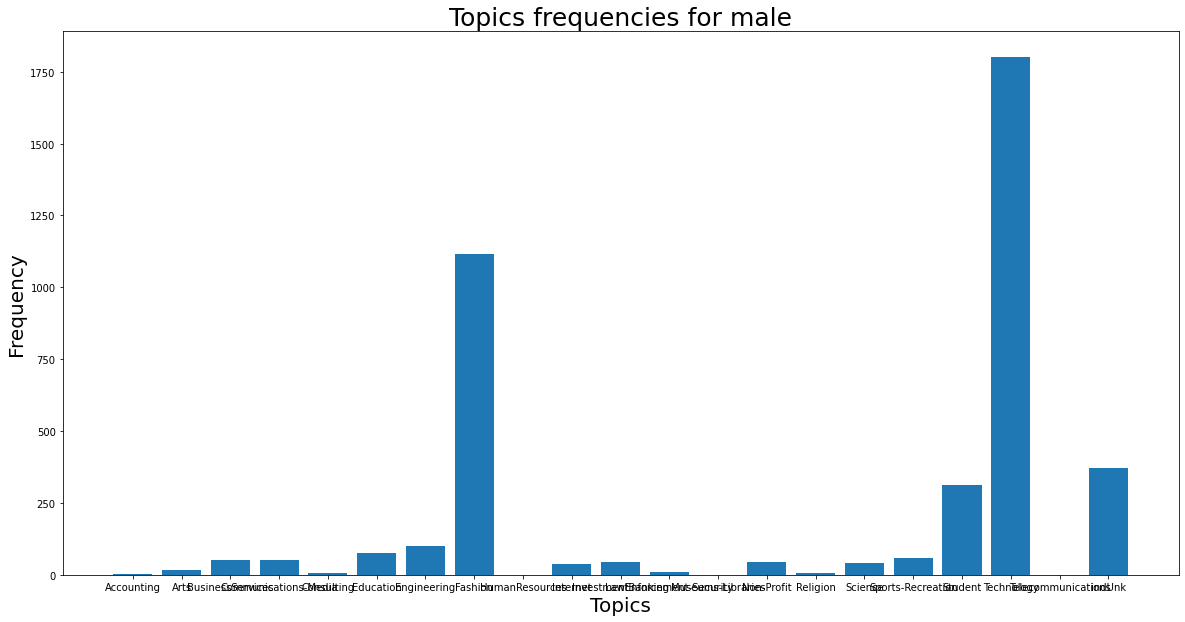

In [15]:
plot_frequency_distribution(data_train_preprocessed, "male")

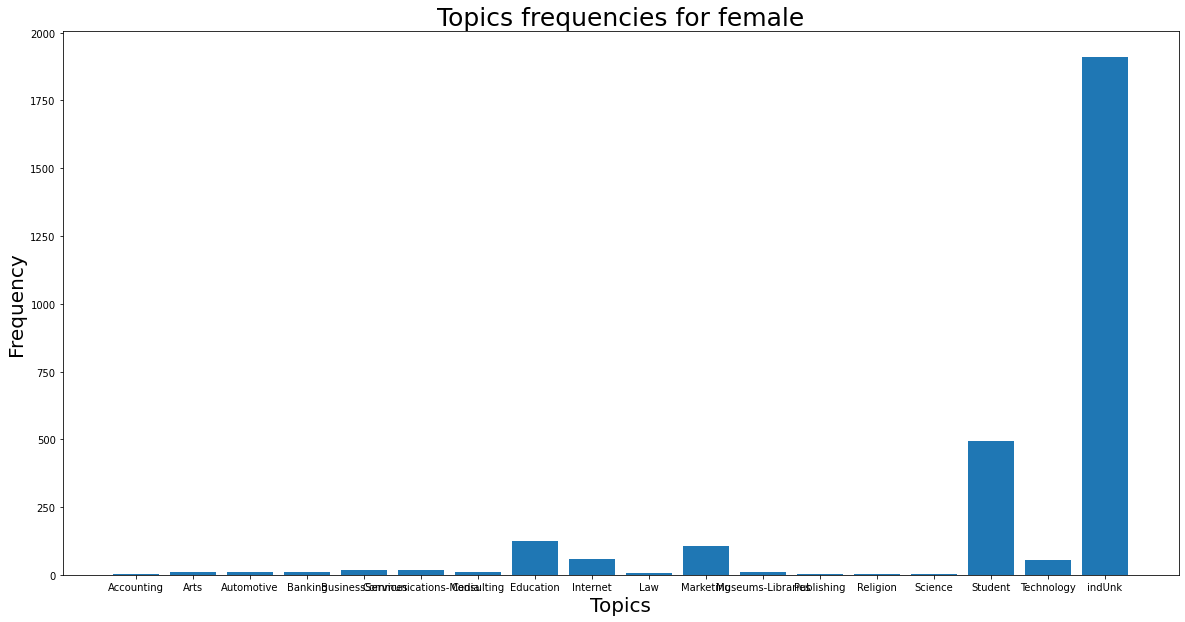

In [16]:
plot_frequency_distribution(data_train_preprocessed, "female")

### 5.2. Classification traditionnelle à base de textes (35%)

In [17]:
def tf_idf(processed_train_df, processed_val_df, N, n_grams) :
    #A partir des dataframes pré-traités de questions et de paragraphes, d'une taille de vocabulaire N et 
    #d'un couple n_grams, renvoie une matrice TF-IDF ainsi que son vectorizer associé
    processed_train_df_copy = processed_train_df.copy()
    processed_train_df_copy["processed_text"] = processed_train_df_copy["processed_text"].apply(lambda x: " ".join(x))
    processed_val_df_copy = processed_val_df.copy()
    processed_val_df_copy["processed_text"] = processed_val_df_copy["processed_text"].apply(lambda x: " ".join(x))
    vectorizer = TfidfVectorizer(smooth_idf=False, max_features = N, ngram_range = n_grams)
    vectorizer.fit(processed_train_df_copy["processed_text"])
    tfidf_train = vectorizer.transform(processed_train_df_copy["processed_text"]) 
    tfidf_val = vectorizer.transform(processed_val_df_copy["processed_text"])
    print("Vocabulary :" + "\n\n", vectorizer.get_feature_names())
    return tfidf_train, tfidf_val, vectorizer

In [18]:
def logistic_regression_model(xtrain, ytrain) :
    model = LogisticRegression(max_iter = 1000)
    model.fit(xtrain,ytrain)
    return model

In [19]:
def naive_bayes_classifier(xtrain, ytrain) :
    model = GaussianNB()
    model.fit(xtrain,ytrain)
    return model

In [20]:
def compute_mape(y, ypred) :
    return np.sum(abs(y-ypred))/len(y)

In [21]:
Y_train = data_train_preprocessed["gender"].apply(lambda sex: 0 if sex == "male" else 1).to_numpy()
Y_val = data_val_preprocessed["gender"].apply(lambda sex: 0 if sex == "male" else 1).to_numpy()

1. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame du contenu des blogues, pondéré avec TF-IDF.

In [22]:
#Datasets and vectorizer for the unigram model
X_train_11, X_val_11, vectorizer_11 = tf_idf(data_train_preprocessed, data_val_preprocessed, N, (1,1))

Vocabulary :

 ['00', '000', '00am', '00pm', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '102', '103', '107', '108', '10am', '10pm', '10th', '11', '110', '11am', '11pm', '11th', '12', '120', '125', '12th', '13', '130', '13th', '14', '14th', '15', '150', '1500', '15am', '15pm', '15th', '16', '1600', '16th', '17', '17th', '18', '1860', '1863', '18th', '19', '1940', '1950', '1956', '1975', '1979', '1980', '1983', '1984', '1988', '1989', '1990', '1990s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '20th', '21', '21st', '22', '23', '23rd', '24', '25', '250', '25th', '26', '26th', '27', '27th', '28', '28th', '29', '29th', '2am', '2b', '2day', '2nd', '2pm', '30', '300', '3000', '30am', '30pm', '30th', '31', '32', '33', '34', '35', '36', '3650', '37', '38', '39', '3am', '3pm', '3rd', '40', '400', '41', '42', '43', '44', '45', '45pm', '46', '47', '48', '49', '4am

* Pour la régression logistique

In [24]:
log_regression_model_11 = logistic_regression_model(X_train_11, Y_train)

In [25]:
Y_val_predicted_lr_11 = log_regression_model_11.predict(X_val_11)

In [26]:
compute_mape(Y_val, Y_val_predicted_lr_11)

0.196

* Pour le classificateur Naïve Bayes

In [27]:
naive_bayes_model_11 = naive_bayes_classifier(X_train_11.toarray(), Y_train)

In [28]:
Y_val_predicted_nb_11 = naive_bayes_model_11.predict(X_val_11.toarray())

In [29]:
compute_mape(Y_val, Y_val_predicted_nb_11)

0.289

2. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame **et** bigramme du contenu des blogues, pondéré avec TF-IDF.

* Pour la régression logistique

In [30]:
#Datasets and vectorizer for the unigram/bigram model
X_train_12, X_val_12, vectorizer_12 = tf_idf(data_train_preprocessed, data_val_preprocessed, N, (1,2))

Vocabulary :

 ['00', '00 pm', '000', '000 people', '000 year', '00am', '00pm', '02', '03', '04', '05', '06', '07', '08', '09', '10', '10 000', '10 15', '10 30', '10 day', '10 minute', '10 pm', '10 time', '10 year', '100', '100 000', '1000', '101', '10am', '10pm', '10th', '11', '11 30', '11pm', '11th', '12', '12 00', '12 30', '12 hour', '12 year', '13', '130', '13th', '14', '14 year', '15', '15 minute', '15 year', '150', '16', '16 year', '17', '18', '1860', '18th', '19', '1956', '1989', '1990', '1992', '1995', '1996', '1998', '1999', '19th', '1st', '20', '20 minute', '20 year', '200', '200 000', '2000', '2001', '2002', '2003', '2004', '2005', '20th', '21', '21st', '22', '23', '24', '24 hour', '25', '250', '26', '27', '27th', '28', '29', '2am', '2day', '2nd', '2pm', '30', '30 day', '30 min', '30 minute', '30 morning', '300', '30am', '30pm', '31', '32', '33', '34', '34 pm', '35', '36', '37', '38', '39', '3rd', '40', '40 year', '400', '41', '41 pm', '42', '43', '44', '45', '45 minute', '4

In [31]:
log_regression_model_12 = logistic_regression_model(X_train_12, Y_train)

In [32]:
Y_val_predicted_lr_12 = log_regression_model_12.predict(X_val_12)

In [33]:
compute_mape(Y_val, Y_val_predicted_lr_12)

0.204

* Pour le classificateur Naïve-Bayes

In [34]:
naive_bayes_model_12 = naive_bayes_classifier(X_train_12.toarray(), Y_train)

In [35]:
Y_val_predicted_nb_12 = naive_bayes_model_12.predict(X_val_12.toarray())

In [36]:
compute_mape(Y_val, Y_val_predicted_nb_12)

0.279

3. (5 points) Testez vos deux modèles et retournez les valeurs des métriques d’évaluation: précision globale (accuracy) et précision, rappel et F1-score par classe. Affichez aussi les macro moyennes pour toutes ces métriques.

In [37]:
def evaluate_metrics(yval, ypred) :
    return {
        "Precision": precision_score(yval, ypred), 
        "Precision Macro": precision_score(yval, ypred, average="macro"), 
        "Accuracy": accuracy_score(yval, ypred), 
        "Recall": recall_score(yval, ypred),
        "Recall Macro": recall_score(yval, ypred, average="macro"),
        "F1": f1_score(yval, ypred), 
        "F1 Macro": f1_score(yval, ypred)
    }

In [38]:
print("Métrique d'évaluation pour le modèle de regression logistique: (unigrame)")
evaluate_metrics(Y_val, Y_val_predicted_lr_11)

Métrique d'évaluation pour le modèle de regression logistique: (unigrame)


{'Precision': 0.8095238095238095,
 'Precision Macro': 0.805364314400459,
 'Accuracy': 0.804,
 'Recall': 0.6732673267326733,
 'Recall Macro': 0.7829423881985514,
 'F1': 0.7351351351351353,
 'F1 Macro': 0.7351351351351353}

In [39]:
print("Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame)")
evaluate_metrics(Y_val, Y_val_predicted_nb_11)

Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame)


{'Precision': 0.6210526315789474,
 'Precision Macro': 0.70671679197995,
 'Accuracy': 0.711,
 'Recall': 0.7301980198019802,
 'Recall Macro': 0.7140922984915941,
 'F1': 0.6712172923777019,
 'F1 Macro': 0.6712172923777019}

In [40]:
print("Métrique d'évaluation pour le modèle de regression logistique: (unigrame et bigrame)")
evaluate_metrics(Y_val, Y_val_predicted_lr_12)

Métrique d'évaluation pour le modèle de regression logistique: (unigrame et bigrame)


{'Precision': 0.7958579881656804,
 'Precision Macro': 0.7959652478592752,
 'Accuracy': 0.796,
 'Recall': 0.6658415841584159,
 'Recall Macro': 0.7750348860389396,
 'F1': 0.7250673854447438,
 'F1 Macro': 0.7250673854447438}

In [41]:
print("Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame et bigrame)")
evaluate_metrics(Y_val, Y_val_predicted_nb_12)

Métrique d'évaluation pour le classificateur Naive Bayes: (unigrame et bigrame)


{'Precision': 0.6278118609406953,
 'Precision Macro': 0.7189939930926568,
 'Accuracy': 0.721,
 'Recall': 0.7599009900990099,
 'Recall Macro': 0.7272659312911157,
 'F1': 0.6875699888017917,
 'F1 Macro': 0.6875699888017917}

4. (10 points) Trouvez les paramètres optimaux en utilisant un pipeline et GridSearch. Retournez la configuration optimale et sa performance pour chaque algorithme (Naive Bayes, Régression logistique) avec cette configuration en testant les paramètres suivants: 
- Modèle basé sur les mots ou les caractères
- Type de n-gramme (1, 2 et leur combinaison) 
- Utilisation ou non de TF-IDF
- Minuscule avec TF-IDF ou non
- Taille du vocabulaire: 5000, 10000, none
- Pour Naive Bayes, testez différentes valeurs du paramètre alpha (bayes__alpha)
- Pour la régression logistique, testez aussi différentes stratégies de régularisation (logistic_penalty)

* Régression logistique : N=None, modèle unigramme
* NB : N=10000, modèle unigramme/bigramme

In [42]:
class CombinedAttributesAdder(TransformerMixin):
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        return X.toarray()

X_train = data_train_preprocessed[0:100]["processed_text"].apply(lambda x: " ".join(x))
X_valid = data_val_preprocessed[0:100]["processed_text"].apply(lambda x: " ".join(x))

Y_train = data_train_preprocessed[0:100]["gender"].apply(lambda sex: 0 if sex == "male" else 1)
Y_val = data_val_preprocessed[0:100]["gender"].apply(lambda sex: 0 if sex == "male" else 1)

NB_pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer(smooth_idf=False)),
    ('sparse_to_array', CombinedAttributesAdder()),
    ('nbayes', GaussianNB())
])

NB_param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)], 
    'tfidf__use_idf': [True, False],
    'tfidf__lowercase': [True, False],
    'tfidf__max_features': [5000, 10000, None],
    #'nbayes__alpha': [1, 2, 3]
}


NB_grid_search = GridSearchCV(NB_pipeline, NB_param_grid, cv=5,
            scoring='f1_macro',
            return_train_score=True)

NB_grid_search.fit(X_train, Y_train)

print(NB_grid_search.best_params_)
print(NB_grid_search.best_estimator_)

{'tfidf__analyzer': 'word', 'tfidf__lowercase': True, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': False}
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 smooth_idf=False, use_idf=False)),
                ('sparse_to_array',
                 <__main__.CombinedAttributesAdder object at 0x7f7f377eabb0>),
                ('nbayes', GaussianNB())])


In [42]:
logistic_pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer(smooth_idf=False)),
    ('sparse_to_array', CombinedAttributesAdder()),
    ('logistic', LogisticRegression(max_iter = 1000))
])

logistic_param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)], 
    'tfidf__use_idf': [True, False],
    'tfidf__lowercase': [True, False],
    'tfidf__max_features': [5000, 10000, None],
    #'logistic__penalty': [1, 2, 3]
}


logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5,
            scoring='f1_macro',
            return_train_score=True)

logistic_grid_search.fit(X_train, Y_train)

print(logistic_grid_search.best_params_)
print(logistic_grid_search.best_estimator_)

{'tfidf__analyzer': 'char', 'tfidf__lowercase': True, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (2, 2), 'tfidf__use_idf': True}
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=5000,
                                 ngram_range=(2, 2), smooth_idf=False)),
                ('sparse_to_array',
                 <__main__.CombinedAttributesAdder object at 0x7f6d4106cd00>),
                ('logistic', LogisticRegression(max_iter=1000))])


### 5.3. Classification neuronale (45%)

1. (10 points) Implémentez un modèle à deux couches Bi-LSTM avec Keras sans plongements pré-entrainés et entrainez-le sur l’ensemble d’entrainement (voir les points suivants). Assurez-vous que votre séquence maximale prenne en compte la plus longue séquence de votre ensemble de données d’entrainement.

In [9]:
max_features = 2000
maxlen = 200
embedding_dim = 128

In [10]:
def get_vocabulary(max_features, maxlen):
    vectorizer = layers.TextVectorization(max_tokens=max_features, output_sequence_length=maxlen)
    vectorizer.adapt(data_train_preprocessed["processed_text"].apply(lambda x: " ".join(x)).to_list())
    vocabulary = vectorizer.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    return word_index, vectorizer

def prepare_data(dataframe, vectorizer):
    y = dataframe["gender"].apply(lambda sex: 0 if sex == "male" else 1).to_list()
    x = vectorizer(dataframe["processed_text"].apply(lambda x: " ".join(x)).to_list())
    #list_of_list_of_words = dataframe["processed_text"].to_list()
    #for list_of_words in list_of_list_of_words:
    #    words = []
    #    for word in list_of_words:
    #        if word in dictionary:
    #            words.append(dictionary[word])
    #    x.append(words)
    return x, np.asarray(y, dtype='float32')
    
def init_basic_model(vocab_length, embedding_dim):
    inputs = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_length, embedding_dim)(inputs)
    #Ajoute 2 LSTMs bidirectionels
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #Ajout d'un classificateur
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [11]:
vocabulary, vectorizer = get_vocabulary(max_features, maxlen)
x_train, y_train = prepare_data(data_train_preprocessed, vectorizer)
x_valid, y_valid = prepare_data(data_val_preprocessed, vectorizer)
x_test, y_test = prepare_data(data_test_preprocessed, vectorizer)

basic_model = init_basic_model(max_features, embedding_dim)
basic_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         256000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 453,761
Trainable params: 453,761
Non-trainable params: 0
_________________________________________________________________


2. (2 points) Effectuez un «EarlyStopping» prenant en compte une «val_loss» minimale et en attendant 3 époques.

In [12]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

3. (2 points) En utilisant un ModelCheckpoint, sauvegardez votre meilleur modèle pour lequel la métrique «val_accuracy» soit maximale.

In [13]:
basic_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./history_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [14]:
his = basic_model.fit(
    x=x_train,
    y=y_train,
    batch_size=embedding_dim,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping_callback, basic_model_checkpoint_callback])

Epoch 1/10
55/55 [==============================] - 22s 337ms/step - loss: 0.6430 - accuracy: 0.6360 - val_loss: 0.5394 - val_accuracy: 0.7400
Epoch 2/10
55/55 [==============================] - 19s 352ms/step - loss: 0.4684 - accuracy: 0.7857 - val_loss: 0.4779 - val_accuracy: 0.7760
Epoch 3/10
55/55 [==============================] - 20s 363ms/step - loss: 0.3769 - accuracy: 0.8340 - val_loss: 0.4524 - val_accuracy: 0.7880
Epoch 4/10
55/55 [==============================] - 21s 382ms/step - loss: 0.3112 - accuracy: 0.8703 - val_loss: 0.4643 - val_accuracy: 0.7830
Epoch 5/10
55/55 [==============================] - 21s 386ms/step - loss: 0.2604 - accuracy: 0.8916 - val_loss: 0.5395 - val_accuracy: 0.7810
Epoch 6/10
55/55 [==============================] - 21s 382ms/step - loss: 0.2359 - accuracy: 0.9030 - val_loss: 0.5657 - val_accuracy: 0.7780


4. (5 points) Affichez dans une figure la fonction de perte / époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

In [15]:
def generate_model_history(history, monitor, ylabel, title):
    plt.plot(history.history[monitor])
    plt.plot(history.history['val_' + monitor])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

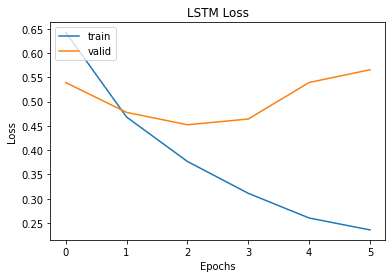

In [16]:
generate_model_history(his, 'loss', 'Loss', 'LSTM Loss')

5. (5 points) Affichez dans une figure la précision globale (accuracy)/ époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

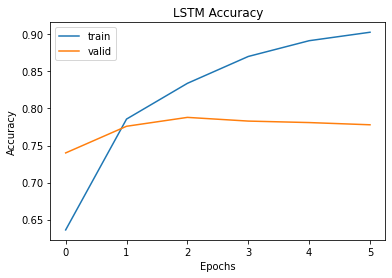

In [17]:
generate_model_history(his, 'accuracy', 'Accuracy', 'LSTM Accuracy')

6. (2 points) Chargez le meilleur modèle retenu, et affichez les performances de ce meilleur modèle sur l’ensemble de test. Utilisez la métrique Accuracy. (Exemple: Accuracy: 0.82)

In [18]:
basic_model.load_weights('./history_checkpoint')
scores = basic_model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

Accuracy: 76.84999704360962%


7. (10 points) En utilisant des plongements lexicaux pré-entrainés GLOVE, implémentez un modèle Bi-LSTM à deux couches avec Keras utilisant ces plongements et avec les mêmes critères d’EarlyStopping et de ModelCheckpoint que précédemment, et entrainez-le sur l’ensemble d’entrainement. Sauvegardez votre meilleur modèle. 

In [109]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-10-13 22:07:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-13 22:07:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-13 22:07:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
def get_embeddings_index_from_glove(glove_file):
    embeddings_index = {}
    with open(glove_file) as file:
        for line in file:
            elements = line.split(' ')
            word = elements[0]
            coefs = [float(element) for element in elements[1:]]
            embeddings_index[word] = coefs
    return embeddings_index

def get_embedding_matrix(max_features, embedding_dimension, vocabulary, embedding_index):
    embedding_matrix = np.zeros((max_features, embedding_dimension))
    hits = 0
    misses = 0
    for word, i in vocabulary.items():
        if word not in embeddings_index:
            misses += 1
            continue
        embedding_matrix[i] = embeddings_index[word]
        hits += 1
    print(f'Succeeded to convert {hits} words! Missed {misses} words!')
    return embedding_matrix

def initi_keras_model_glove(max_features, embedding_dim, embedding_matrix):
    inputs = keras.Input(shape=(None,), dtype="int32")
    embedding_layer = layers.Embedding(
        max_features,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
    x = embedding_layer(inputs)
    #Ajoute 2 LSTMs bidirectionels
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #Ajout d'un classificateur
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [20]:
embedding_dim = 200
vocabulary, vectorizer = get_vocabulary(max_features, maxlen)
embeddings_index = get_embeddings_index_from_glove('glove.6B.200d.txt')
embedding_matrix = get_embedding_matrix(max_features + 2, embedding_dim, vocabulary, embeddings_index)
model_with_glove = initi_keras_model_glove(max_features + 2, embedding_dim, embedding_matrix)

Succeeded to convert 1987 words! Missed 13 words!
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 200)         400400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         135680    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 635,025
Trainable params: 234,625
Non-trainable params: 400,400
_________________________________________________________________


In [21]:
model_glove_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./history_glove_checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
model_with_glove.compile("adam", "binary_crossentropy", metrics=["accuracy"])
his_with_glove = model_with_glove.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping_callback, model_glove_checkpoint_callback])

Epoch 1/10
35/35 [==============================] - 19s 455ms/step - loss: 0.6466 - accuracy: 0.6349 - val_loss: 0.6034 - val_accuracy: 0.6840
Epoch 2/10
35/35 [==============================] - 16s 469ms/step - loss: 0.5828 - accuracy: 0.6946 - val_loss: 0.5737 - val_accuracy: 0.7070
Epoch 3/10
35/35 [==============================] - 17s 487ms/step - loss: 0.5500 - accuracy: 0.7259 - val_loss: 0.5656 - val_accuracy: 0.7150
Epoch 4/10
35/35 [==============================] - 18s 508ms/step - loss: 0.5342 - accuracy: 0.7309 - val_loss: 0.5400 - val_accuracy: 0.7290
Epoch 5/10
35/35 [==============================] - 19s 532ms/step - loss: 0.5010 - accuracy: 0.7536 - val_loss: 0.5292 - val_accuracy: 0.7470
Epoch 6/10
35/35 [==============================] - 18s 508ms/step - loss: 0.4739 - accuracy: 0.7711 - val_loss: 0.5473 - val_accuracy: 0.7150
Epoch 7/10
35/35 [==============================] - 19s 542ms/step - loss: 0.4481 - accuracy: 0.7903 - val_loss: 0.5236 - val_accuracy: 0.7540

8. (2 points) De la même manière que précédemment, affichez dans deux figures la fonction de perte et la précision globale (accuracy) / époque sur le jeu de données d’entrainement (train) et de validation (val).

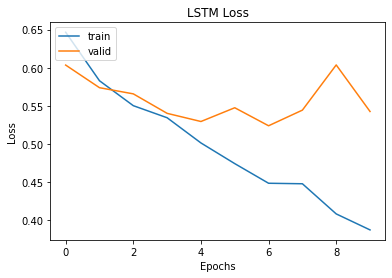

In [22]:
generate_model_history(his_with_glove, 'loss', 'Loss', 'LSTM Loss')

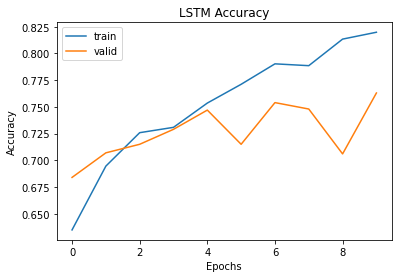

In [23]:
generate_model_history(his_with_glove, 'accuracy', 'Accuracy', 'LSTM Accuracy')

9. (2 points) Affichez les performances de votre meilleur modèle à base de plongements sur l’ensemble de test. Utilisez la métrique de précision globale (Accuracy).

In [24]:
model_with_glove.load_weights('./history_glove_checkpoint')
scores = model_with_glove.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100}%')

Accuracy: 73.69999885559082%


10. (5 points) Si ce n’est pas déjà le cas, tentez de dépasser les performances de votre meilleur modèle traditionnel en créant un nouveau modèle Bi-LSTM (vous pouvez ajouter des couches, utiliser du dropout, utiliser d’autres modèles de plongements, etc.)

### 5.4. Évaluation (10%)

1. (4 points) Affichez une table récapitulative comparant les performances de vos différents modèles sur l’ensemble de test.

2. (6 points) Indiquez votre conclusion dans une cellule (Meilleur algorithme? Meilleure configuration pour l’apprentissage machine «traditionnel»? Effets du GridSearch? Meilleur modèle Bi-LSTM?)

## LIVRABLES
Vous devez remettre sur Moodle:
1. Le code: Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source._ Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié;
4. Un document _contributions.txt_: Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisseeffectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- **Règle 1:**  Le plagiat de code est bien évidemment interdit.
- **Règle 2:** Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- **Règle 3:**  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
